In [12]:
import numpy as np
import matplotlib

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import os
from scipy.misc import derivative
from scipy.integrate import solve_bvp
from functools import partial
from scipy import special as sp
from scipy import stats
import plasmapy.mathematics
import scipy.optimize as op
from functools import partial
from scipy import fftpack
from scipy import integrate
import scipy.signal
%config InlineBackend.figure_format = 'svg'
#%matplotlib notebook

In [56]:
k_list = []
wr_list = []
wi_list = []

In [179]:
k_list2 = []
wr_list2 = []
wi_list2 = []

## Public Parameters

In [166]:
tem = 1
k_wave = 0.1
L = 2*np.pi / k
vmax = 5  # 10 * np.sqrt(tem)
nx = 1001
nv = 201
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)
V, X = np.meshgrid(v, x)
dt = 0.01
max_steps  = 10000
data_steps = 10000
data_num = int(max_steps/data_steps)+1
d = 0.001
kappa = 5.0

path = '../data/'

m=1
n=1
q=1
v_th = np.sqrt(2*tem)
l_D = np.sqrt(tem) # $\lambda_D^2$
w_pe = 1
print("data_num = ",data_num)

print("k = ",k)
print('limited time=',2*np.pi/k/dv)
print('real time = ', max_steps*dt)

data_num =  2
k =  0.05
limited time= 2513.274122871834
real time =  100.0


## 理论公式
$$n_e^* = A\left[1-\frac{\Delta}{k^2 \lambda^2 \kappa_0} \cos(kx)\right]^{-\kappa_0-1}$$
$$n_i^* = A\left[1-\frac{\Delta}{k^2 \lambda^2 \kappa_0} \cos(kx)\right]^{-\kappa_0-1} + \Delta \cos(kx)$$
$$A^{-1} = \int_0^L \left[1-\frac{\Delta}{k^2 \lambda^2 \kappa_0} \cos(kx)\right]^{-\kappa_0-1} dx$$

## Func Defs

In [167]:
B = (d/k**2/kappa/l_D**2)


def unnorm_n(x):
    r = (1 - B * np.cos(k*x))**(-kappa-1)
    return r


norm = integrate.quad(unnorm_n, 0, L)
#print(norm)


def ne(x):
    r = L * 1 / norm[0] * unnorm_n(x)
    return r


def ni(x):
    r = ne(x) + d*np.cos(k*x)
    return r


def T_theo(x):
    return tem*ne(x)**(-1.0/(kappa+1))


def f_homo(v, t, kappa):
    if(kappa == 0):
        r = np.sqrt(1./(2.*np.pi*t))*np.exp(-v**2/(2*t))
    else:
        r = np.sqrt(m/(2.*np.pi*t*kappa)) * sp.gamma(kappa+1.5) / \
            sp.gamma(kappa+1) * (1 + m*v**2 / kappa / 2 / t) ** (-kappa-1.5)
    return r


def f_inhomo(x, v, kappa):
    t = T_theo(x)
    if(kappa == 0):
        r = f_homo(v, t, kappa)
    else:
        r = ne(x)*np.sqrt(m/(2.*np.pi*t*kappa)) * sp.gamma(kappa+1.5) / \
            sp.gamma(kappa+1) * (1 + m*v**2 / kappa / 2 / t) ** (-kappa-1.5)
    return r


def fv_nonvec(vv, kk):
    r = integrate.quad(partial(f_inhomo, v=vv, kappa=kk), 0, L)[0]
    return r


fv_theo = np.vectorize(fv_nonvec)

def line(p, x):
    k, b = p
    return k*x+b


def errorWithLine(p, x, y):
    r = line(p, x)-y
    return r


def period(x):
    return (x[1]-x[0])/1.


def errPercent(a, b):
    r = abs((a-b)/b)
    return r


def PlotWaveFreq(t,y,refFreq):
    n = t.size
    y_k = fftpack.fft(y)
    x_k = fftpack.fftfreq(len(y_k),dt)
    y_k_abs = np.abs(y_k)
    y_k_phi = np.angle(y_k)

    plt.figure(figsize=(10,3))
    
    ax2 = plt.subplot()
    k_plot_scale=n//50
    ax2.plot(2*np.pi*x_k[0:k_plot_scale],2*y_k_abs[0:k_plot_scale]/n,color='black',lw=2)
    ax2.axvline(refFreq,color='red',ls='--',label=r'$\omega_{ref}$ = '+str(round(refFreq,6)))
    ax2.set_title('FFT analyze')
    ax2.set_xlabel(r'$\omega$')
    ax2.set_ylabel('A')
    ax2.grid()
    ax2.legend()
    
    plt.show()

## 数据读取

In [251]:
k_wave = 0.1

In [252]:
progesses = np.arange(0,data_num,1)

f = []
phi = []

for progess in progesses:
    f_temp = np.loadtxt(os.path.join(path,"data"+str(progess)))
    f.append(f_temp)
    phi_temp = np.loadtxt(os.path.join(path,"phi"+str(progess)))
    phi.append(phi_temp)

## 定态展示

In [253]:
dataet = np.loadtxt(os.path.join(path, "tot_energy"))[0:max_steps]
dataep = np.loadtxt(os.path.join(path, "pot_energy"))[0:max_steps]
dataek = np.loadtxt(os.path.join(path, "kin_energy"))[0:max_steps]

t = np.linspace(0, max_steps, max_steps)

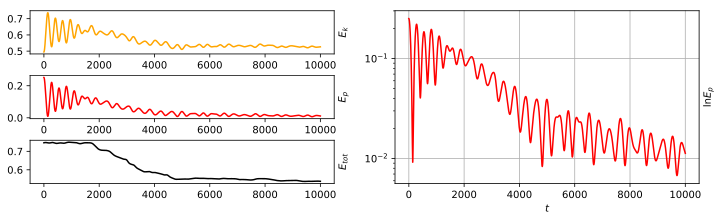

In [254]:
fig = plt.figure(figsize=(12, 3))

ax1 = plt.subplot2grid((3, 2), (0, 0))
ax1.plot(t, dataek, color='orange')
ax1.set_ylabel(r'$E_k$')
ax1.yaxis.set_label_position("right")

ax2 = plt.subplot2grid((3, 2), (1, 0))
ax2.plot(t, dataep, color='r')
ax2.set_ylabel(r'$E_p$')
ax2.yaxis.set_label_position("right")

ax3 = plt.subplot2grid((3, 2), (2, 0))
ax3.plot(t, dataet, color='black')
ax3.set_ylabel(r'$E_{tot}$')
ax3.yaxis.set_label_position("right")

axl2 = plt.subplot2grid((3, 2), (0, 1), rowspan=3)
axl2.plot(t, dataep, color='r')
axl2.set_ylabel(r'$\ln E_p$')
axl2.set_yscale('log')
axl2.yaxis.set_label_position("right")
axl2.grid()

fig.subplots_adjust(bottom=0.1, top=0.9, hspace=.5, wspace=.2)
plt.xlabel(r'$t$')
plt.show()

In [255]:
indexes, _ = scipy.signal.find_peaks(dataep, distance=5)
xep = indexes[0:4:1]
yep = np.log(dataep[xep])
para, nouse = op.leastsq(errorWithLine, [-1, 1], args=(xep, yep))
per_sim = period(xep) * dt
wr_sim = 2*np.pi/per_sim/2
wi_sim = para[0]/dt/2
print('simulation results: ')
print('wr = ', wr_sim)
print('wi = ', wi_sim)

simulation results: 
wr =  1.176626462018649
wi =  -0.014070744431571303


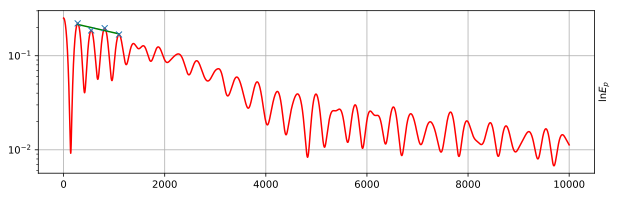

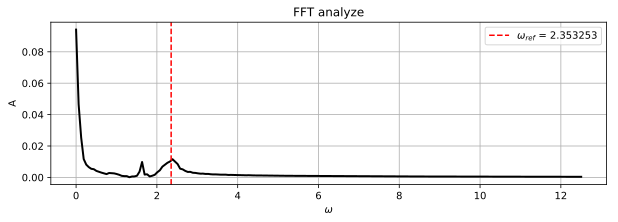

In [256]:
fig = plt.figure(figsize=(10, 3))
ax = plt.gca()
ax.plot(t, dataep, color='r')
ax.plot(xep,np.exp(line(para,xep)), '-',color='green')

ax.plot(xep,dataep[xep],'x')
ax.set_ylabel(r'$\ln E_p$')
ax.set_yscale('log')
ax.yaxis.set_label_position("right")
plt.grid()
plt.show()

PlotWaveFreq(t,dataep,2*wr_sim)

In [257]:
k_list2.append(k_wave)
wr_list2.append(wr_sim)
wi_list2.append(wi_sim)

In [258]:
print('k_wave = ',k_list2)
print('wr = ',wr_list2)
print('wi = ',wi_list2)

k_wave =  [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
wr =  [2.0943951023931953, 1.927357456190057, 1.7649396930279737, 1.644812907638635, 1.539996398818526, 1.4410975475182537, 1.3368479376977842, 1.266771231286207, 1.176626462018649]
wi =  [-0.23518782623821288, -0.27766535213919974, -0.2723351444278641, -0.222254852266817, -0.13324394655389593, -0.07823684154496931, -0.033028421990817514, -0.014437556075047339, -0.014070744431571303]


In [154]:
import quadpy
def dispersion_function(zeta):
    r = 0.0
    A_kappa = (kappa)**(-1.5) * sp.gamma(kappa+1) / sp.gamma(kappa-0.5)
    def integrand(xi):
        return  (1+xi**2/kappa)**(-kappa-1)
        #return np.exp(-xi**2)
    if zeta.imag>0:
        r = (1/np.sqrt(np.pi)) * quadpy.quad(lambda xi: integrand(xi)/(xi-zeta),-np.inf,np.inf)[0]
    elif zeta.imag==0:
        x = 0.1
        s_p = zeta.real + x
        s_n = zeta.real - x
        real1 = (1/np.sqrt(np.pi)) * integrate.quad(integrand,s_n,s_p, weight='cauchy',wvar=zeta.real)[0]
        real2 = (1/np.sqrt(np.pi)) * quadpy.quad(lambda xi: integrand(xi)/(xi-zeta),-np.inf,s_n)[0]
        real3 = (1/np.sqrt(np.pi)) * quadpy.quad(lambda xi: integrand(xi)/(xi-zeta),s_p,np.inf)[0]
        real = real1+real2+real3
        imag = np.sqrt(np.pi) * integrand(zeta)
        r = real + 1j*imag
    elif zeta.imag<0:
        x = 1e-8
        s_p = zeta.real + x
        s_n = zeta.real - x
        real1a = -1j * quadpy.quad(lambda xi_i: integrand(s_n+1j*xi_i)/(1j*xi_i-1j*zeta.imag-x),zeta.imag,0)[0]
        real1b =  1j * quadpy.quad(lambda xi_i: integrand(s_p+1j*xi_i)/(1j*xi_i-1j*zeta.imag+x),zeta.imag,0)[0]
        real2 = quadpy.quad(lambda xi: integrand(xi)/(xi-zeta),-np.inf,s_n)[0]
        real3 = quadpy.quad(lambda xi: integrand(xi)/(xi-zeta),s_p,np.inf)[0]
        real = real1a+real1b+real2+real3
        imag = np.sqrt(np.pi) * integrand(zeta)
        r = (1/np.sqrt(np.pi)) * real + 1j*imag
    return r * A_kappa

def eq4PDRK(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    v_th_kappa = np.sqrt(2-3/kappa) * np.sqrt(tem)
    zeta = wc / k /v_th_kappa
    r = 1 + (kappa/(kappa-1.5)) * 1 / k**2 / l_D**2 * ( 1 - 1/2/kappa + zeta*dispersion_function(zeta) )
    return [r.real,r.imag]

k_theo_list = np.linspace(0.2,1,num=100)

In [155]:
s_wr_list,s_wi_list = [],[]
for kk in k_theo_list:
    s=op.root(lambda w:eq4PDRK(w,kk),[1,0.1])
    s_wr,s_wi=s.x
    s_wr_list.append(s_wr)
    s_wi_list.append(s_wi)

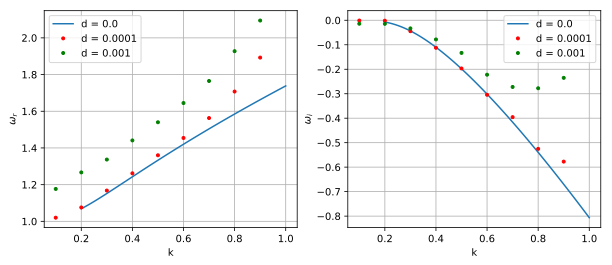

In [259]:
fig = plt.figure(figsize=(10,4))
ax1 = plt.subplot(121)
ax1.plot(k_theo_list,s_wr_list,label='d = 0.0')
ax1.plot(k_list,wr_list,'.',color='r',label='d = 0.0001')
ax1.plot(k_list2,wr_list2,'.',color='g',label='d = 0.001 ')
ax1.set_xlabel('k')
ax1.set_ylabel(r'$\omega_r$')
ax1.grid()
ax1.legend()

ax2 = plt.subplot(122)
ax2.plot(k_theo_list,s_wi_list,label='d = 0.0')
ax2.plot(k_list,wi_list,'.',color='r',label='d = 0.0001')
ax2.plot(k_list2,wi_list2,'.',color='g',label='d = 0.001')
ax2.set_xlabel('k')
ax2.set_ylabel(r'$\omega_i$')
ax2.grid()
ax2.legend()

plt.show()